In [1]:
import rdkit
from rdkit import Chem
import pandas as pd
import numpy as np

# check version
print("rdkit\t", rdkit.__version__)
print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)

rdkit	 2023.03.3
pandas	 2.1.1
numpy	 1.26.0


# RDKit Basics

**Installation**: `conda install -c conda-forge rdkit`


**RDKit docs**: https://www.rdkit.org/docs/GettingStartedInPython.html

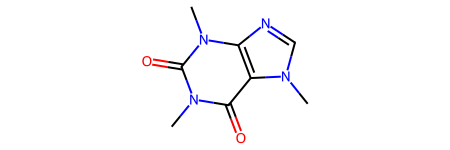

In [2]:
caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
mol = Chem.MolFromSmiles(caffeine)
mol

In [3]:
# There could be multiple SMILES for one molecule.
canonical_smiles = Chem.MolToSmiles(mol)
canonical_smiles == caffeine

False

In [4]:
data = []
for atom in mol.GetAtoms():
    symbol = atom.GetSymbol()
    charge = atom.GetFormalCharge()
    impl_H = atom.GetNumImplicitHs()
    degree = atom.GetDegree()
    inring = atom.IsInRing()
    
    data.append([symbol, charge, impl_H, degree, inring])
    
pd.DataFrame(
    data, 
    columns=["Symbol", "FormalCharge", "NumImplicitHs", "Degree", "IsInRing"]
)

,Symbol,FormalCharge,NumImplicitHs,Degree,IsInRing
0,C,0,3,1,False
1,N,0,0,3,True
2,C,0,1,2,True
3,N,0,0,2,True
4,C,0,0,3,True
5,C,0,0,3,True
6,C,0,0,3,True
7,O,0,0,1,False
8,N,0,0,3,True
9,C,0,0,3,True


In [5]:
data = []
for bond in mol.GetBonds():
    i = bond.GetBeginAtomIdx()
    j = bond.GetEndAtomIdx()
    bond_type = str(bond.GetBondType())
    
    data.append([i, j, bond_type])
    
pd.DataFrame(data, columns=["BeginAtomIdx", "EndAtomIdx", "BondType"])

,BeginAtomIdx,EndAtomIdx,BondType
0,0,1,SINGLE
1,1,2,AROMATIC
2,2,3,AROMATIC
3,3,4,AROMATIC
4,4,5,AROMATIC
5,5,6,AROMATIC
6,6,7,DOUBLE
7,6,8,AROMATIC
8,8,9,AROMATIC
9,9,10,DOUBLE


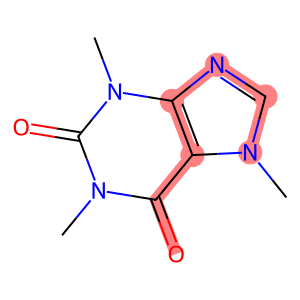

In [6]:
# Visualization
Chem.Draw.MolToImage(
    mol, 
    highlightAtoms=[1, 2, 3, 4, 5], 
    highlightBonds=[1, 2, 3, 4, 5, 6]
)

# Morgan Fingerprint

<p style='text-align: center;'>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FPXIzC%2FbtsaER51rZk%2FuKSG15GVsnMC0GkK9D1rt0%2Fimg.png" width=500>
    <a href="https://biomadscientist.tistory.com/55">
        Img source
    </a>
</p>


In [7]:
# Get dataset
url = (
    'https://raw.githubusercontent.com'\
    '/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv'
)
dataset = pd.read_csv(url)
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


In [8]:
# Transform smiles into RDKit mol representation
molecules = dataset.SMILES.apply(Chem.MolFromSmiles).to_numpy()
molecules

array([<rdkit.Chem.rdchem.Mol object at 0x15327ab20>,
       <rdkit.Chem.rdchem.Mol object at 0x15327ac00>, ...,
       <rdkit.Chem.rdchem.Mol object at 0x153396c70>], dtype=object)

In [9]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Compute molecular descriptor
dataset_fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=2048) for m in molecules]
caffeine_fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)

# Compute Tanimoto similarities. 
# Tanimoto similarity is similar to Jaccard similarity in molecular context.
scores = np.array(DataStructs.BulkTanimotoSimilarity(caffeine_fps, dataset_fps))
indices = np.argsort(scores)


dissimilar_molecules = molecules[indices[:10]]
similar_molecules = molecules[indices[-10::]]

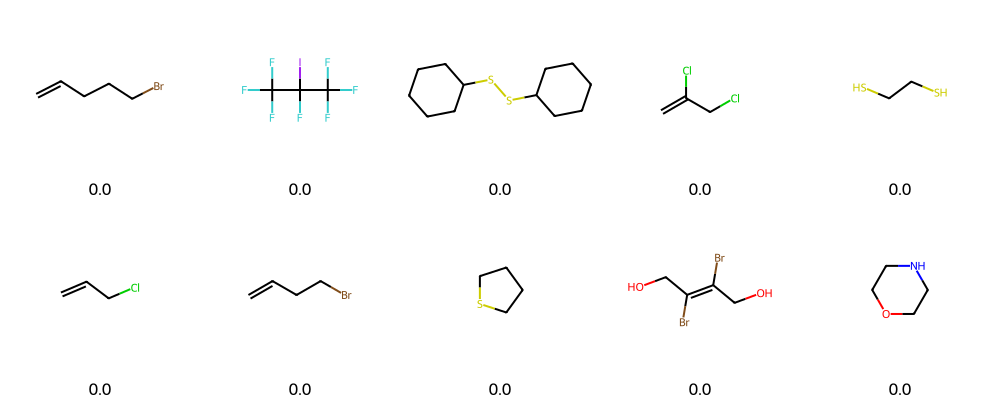

In [10]:
Chem.Draw.MolsToGridImage(
    dissimilar_molecules, 
    molsPerRow=5,
    legends=[str(round(x, 4)) for x in scores[indices[:10]]]
)

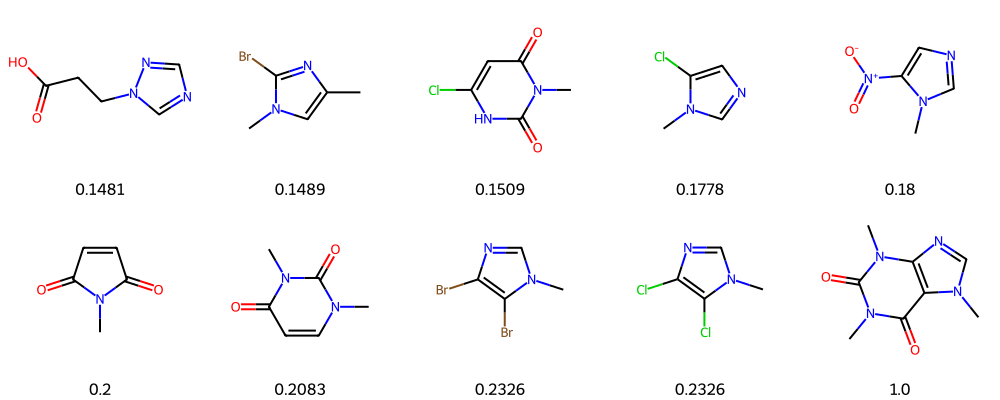

In [11]:
Chem.Draw.MolsToGridImage(
    similar_molecules, 
    molsPerRow=5,
    legends=[str(round(x, 4)) for x in scores[indices[-10:]]]
)

# Edge Case

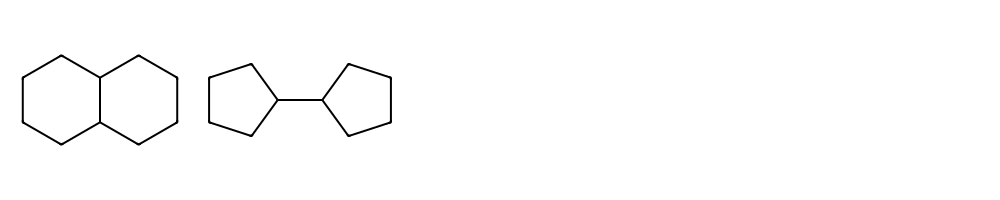

In [12]:
decalin = Chem.MolFromSmiles("C1CCC2CCCCC2C1")
bicyclopentyl  = Chem.MolFromSmiles("C1CCC(C1)C2CCCC2")

Chem.Draw.MolsToGridImage([decalin, bicyclopentyl], molsPerRow=5)

In [13]:
DataStructs.TanimotoSimilarity(
    AllChem.GetMorganFingerprintAsBitVect(decalin, radius=3, nBits=2048),
    AllChem.GetMorganFingerprintAsBitVect(bicyclopentyl, radius=3, nBits=2048)
)

1.0

# References

- datamol docs: https://docs.datamol.io/stable/
    
    `Datamol` is a python library to work with molecules. It's a layer built on top of RDKit and aims to be as light as possible.

---

- LAIDD: https://www.laidd.org/

    AI 신약개발 강의 플랫폼. RDKit에 대한 보다 자세한 설명은 물론, 신약개발에 필요한 전범위의 강의를 볼 수 있다.

# Question

- SMILES representation을 사용할 경우 생길 만한 문제점이 있다면?